In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold ## for regression
from sklearn.model_selection import StratifiedKFold ## recommended for classification
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn import tree
import graphviz

import matplotlib.pyplot as plt

import itertools
import statsmodels.api as sm

# Data

In [ ]:
train_df = pd.read_csv('option_train.csv')
test_df = pd.read_csv('option_test_wolabel.csv')

# Exploratory Data Analysis (EDA)

In [ ]:
train_df.describe(include='all')

,Value,S,K,tau,r,BS
count,1678.000000,1679.000000,1678.000000,1679.000000,1680.000000,1680
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,Under
freq,NaN,NaN,NaN,NaN,NaN,946
mean,15.068709,464.402535,438.241955,0.437519,0.030235,NaN
std,14.040023,973.652179,23.408989,7.057555,0.000557,NaN
min,0.125000,0.000000,375.000000,0.003968,0.029510,NaN
25%,2.255001,433.863864,420.000000,0.119048,0.029820,NaN
50%,11.190967,442.634081,440.000000,0.202381,0.030130,NaN
75%,25.747434,447.320414,455.000000,0.285714,0.030540,NaN


In [ ]:
test_df.describe(include='all')

,S,K,tau,r
count,1120.000000,1120.000000,1120.000000,1120.000000
mean,441.110753,440.406250,0.203589,0.030223
std,7.630218,23.788616,0.103300,0.000542
min,425.472331,375.000000,0.003968,0.029510
25%,433.734305,420.000000,0.115079,0.029820
50%,443.411426,440.000000,0.206349,0.030130
75%,447.350699,460.000000,0.285714,0.030440
max,455.880619,500.000000,0.392857,0.031880


## Stock price (S)

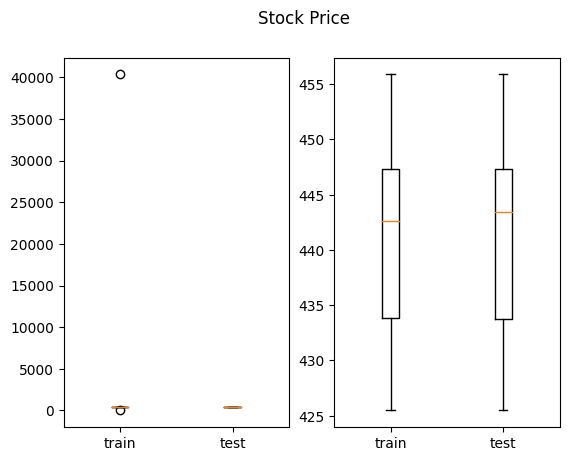

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Stock Price')
axs[0].boxplot((train_df['S'].dropna(), test_df['S']), labels = ["train", "test"])
axs[1].boxplot((train_df.query("0 < S <= 5000").dropna()['S'], test_df['S']), labels = ["train", "test"])
plt.show()

## Strike price (K)

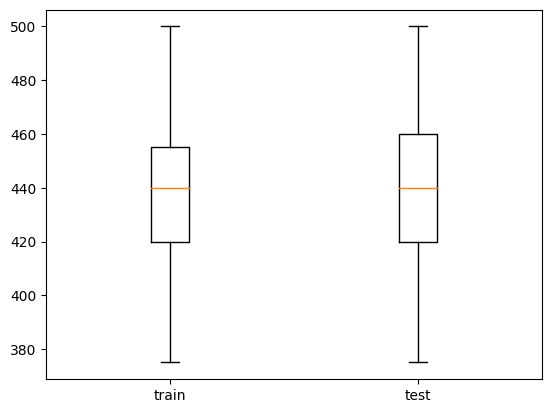

In [ ]:
plt.boxplot((train_df.dropna()['K'], test_df['K']), labels = ["train", "test"])
plt.show()

## Annual risk-free interest rate (r)

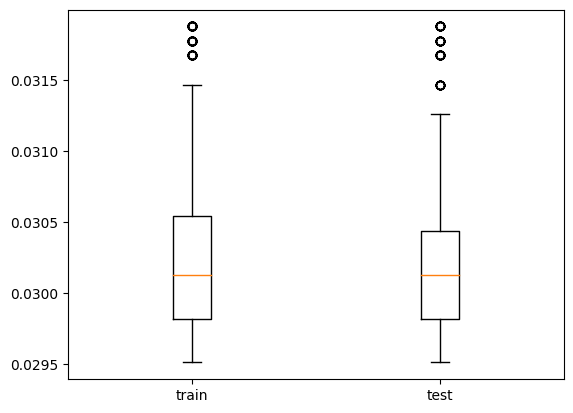

In [ ]:
plt.boxplot((train_df.dropna()['r'], test_df['r']), labels = ["train", "test"])
plt.show()

## Time until expiration of the option (tau)

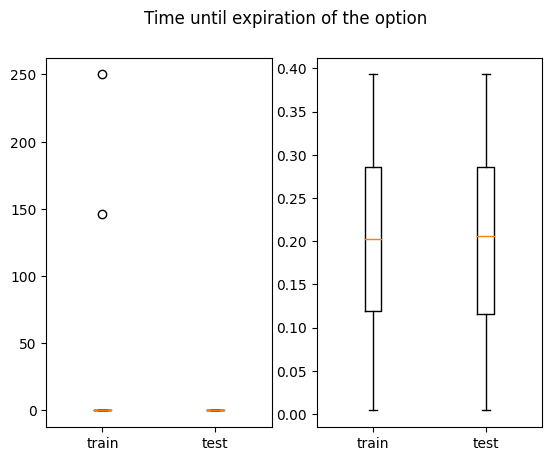

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Time until expiration of the option')
axs[0].boxplot((train_df.dropna()['tau'], test_df['tau']), labels = ["train", "test"])
axs[1].boxplot((train_df.query("0 < tau <= 100").dropna()['tau'], test_df['tau']), labels = ["train", "test"])
plt.show()

## Dependent variables

<Axes: >

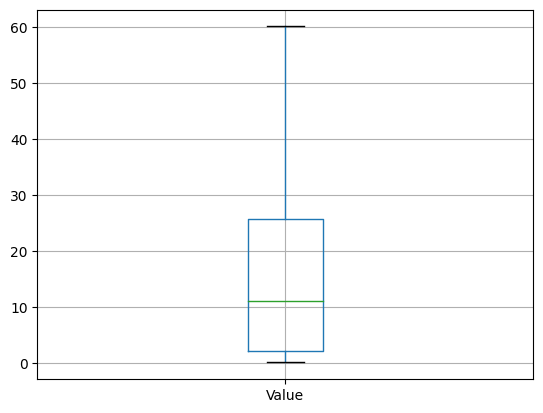

In [ ]:
train_df[['Value']].boxplot()

In [ ]:
train_df['BS'].unique()

array(['Under', 'Over'], dtype=object)

## Scatter

<Axes: xlabel='S', ylabel='Value'>

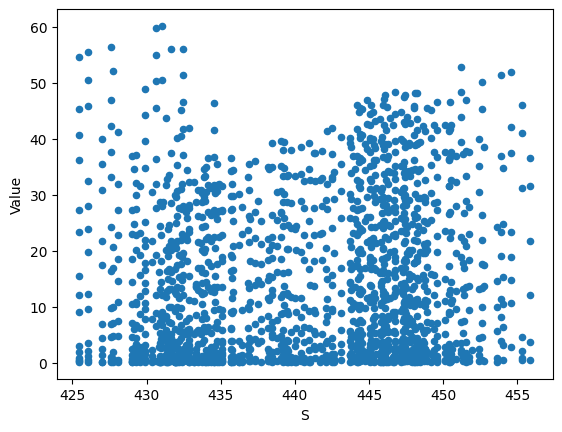

In [ ]:
train_df.query("0 < S < 5000").plot.scatter('S', 'Value')

<Axes: xlabel='K', ylabel='Value'>

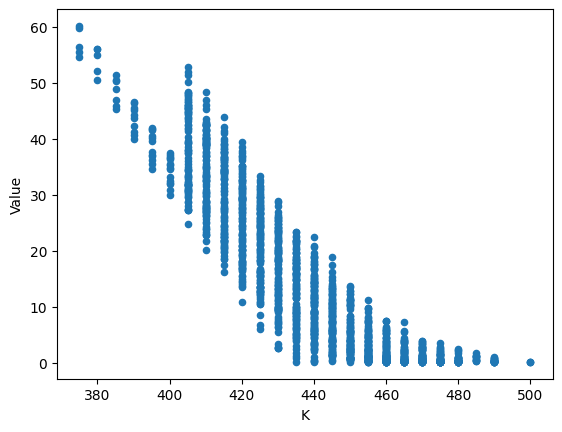

In [ ]:
train_df.plot.scatter('K', 'Value')

<Axes: xlabel='r', ylabel='Value'>

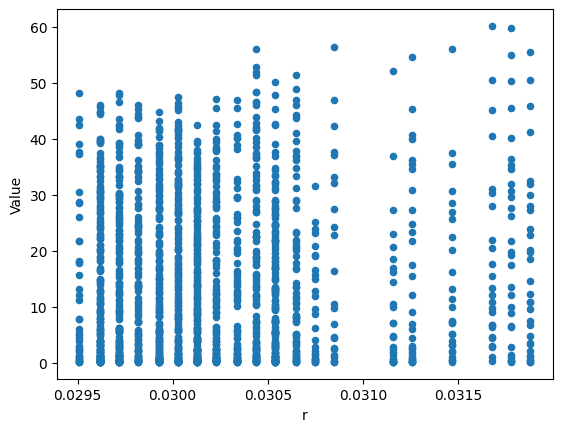

In [ ]:
train_df.plot.scatter('r', 'Value')

<Axes: xlabel='tau', ylabel='Value'>

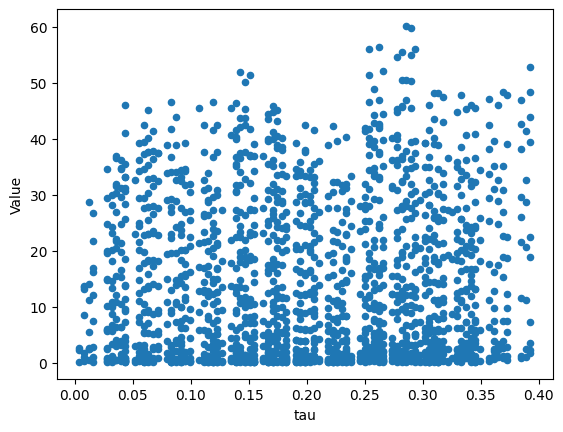

In [ ]:
train_df.query("0 < tau <= 100").plot.scatter('tau', 'Value')

# Cleaning and Engineering

## train_df cleaning

In [ ]:
train_df.query("S.isna() | K.isna() | tau.isna() | r.isna() | Value.isna() | BS.isna()")

,Value,S,K,tau,r,BS
53,NaN,446.718974,430.0,0.166667,0.02962,Under
292,8.625,NaN,NaN,NaN,0.03003,Over
818,NaN,431.284616,NaN,0.230159,0.02972,Over


In [ ]:
train_df_cleaned = train_df.dropna().query("0 < S <= 5000").query("0 < tau <= 100")

# Note: Technically, we can still use an obs with NaN Value for Classification 

In [ ]:
# Create a binary response variable for classification problem
train_df_cleaned['BS_bin'] = np.where(train_df_cleaned['BS'] == "Over", 1, 0)

## Stock price - Strike price

In [ ]:
train_df_cleaned['S_K'] = train_df_cleaned['S'] - train_df_cleaned['K']
test_df['S_K'] = test_df['S'] - test_df['K']

<Axes: xlabel='S_K', ylabel='Value'>

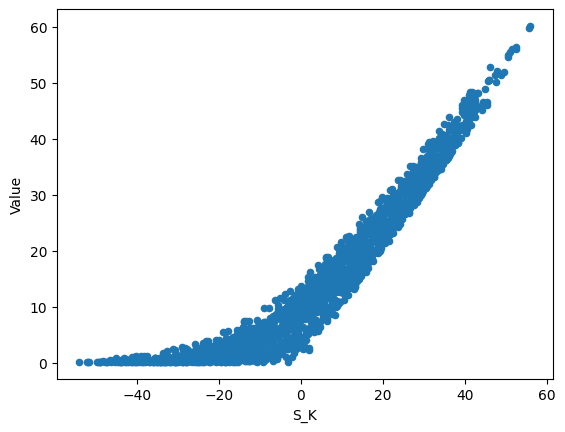

In [ ]:
train_df_cleaned.plot.scatter('S_K', 'Value')

# Value Prediction

In [ ]:
# Define the predictors and responses for regression problem
X_reg = train_df_cleaned[['S', 'K', 'r', 'tau', 'S_K']]
y_reg = train_df_cleaned['Value']

# Split the data into training and testing sets
# X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Use K-fold instead
kfolds_regresssion = KFold(n_splits = 10, random_state = 1, shuffle = True)

In [ ]:
def regression_model(model = LinearRegression(), features = ['S', 'K', 'r', 'tau']):
    
    cv_errors = cross_val_score(model, X_reg[features], y_reg,
                                cv = kfolds_regresssion, scoring = 'r2')

    # Train the linear regression model and make predictions on test data
    model.fit(X_reg[features], y_reg)

    # Errors
    y_train_pred = model.predict(X_reg[features])
    train_r2 = r2_score(y_reg, y_train_pred)
    print('In-sample R-squared for regression problem:', train_r2)
    print('Cross validation R-squared for regression problem:', cv_errors.mean())
    
    return model

## Linear Regression

In [ ]:
# Train the linear regression model and make predictions on test data
reg_model = regression_model(model = LinearRegression(),
                             features = ['S', 'K', 'r', 'tau'])

In-sample R-squared for regression problem: 0.9118804619069916
Cross validation R-squared for regression problem: 0.9100019252948911


In [ ]:
reg_model.coef_

array([  0.6216032 ,  -0.59032948, 515.35157702,  31.63640898])

## Decision Tree

In [ ]:
tree_model = regression_model(model = DecisionTreeRegressor(min_samples_leaf = 30, random_state=42),
                             features = ['S', 'K', 'r', 'tau'])

In-sample R-squared for regression problem: 0.9674548338191321
Cross validation R-squared for regression problem: 0.960426512908402


In [ ]:
# dot_data = tree.export_graphviz(tree_model, out_file=None, 
#                                 feature_names = list(X_reg_train[['S', 'K', 'r', 'tau']].columns),
#                                 filled = True,
#                                 special_characters=True,
#                                 impurity = False
#                                )
# graph = graphviz.Source(dot_data)
# graph.render("DecisionTreeRegressor",
#              format = 'png',
#              cleanup = True)
# graph

In [ ]:
# importance = tree_model.tree_.compute_feature_importances(normalize=True)

# colname = []
# importance_list = []

# # summarize feature importance
# for i, v in enumerate(zip(list(['S', 'K', 'r', 'tau']), importance)):
#     if v[1] > 0:
#         print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
#         colname.append(v[0])
#         importance_list.append(v[1])
    
# # plot feature importance
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.set_dpi(100)
# bars = ax.barh(colname, importance_list)
# ax.bar_label(bars)
# plt.show()

## Random Forest

In [ ]:
# Define the Random Forest Regression model
rf_model = regression_model(model = RandomForestRegressor(n_estimators=100, random_state=42),
                            features = ['S', 'K', 'r', 'tau'])

In-sample R-squared for regression problem: 0.999510751743168
Cross validation R-squared for regression problem: 0.9964412626657095


# Classification

In [ ]:
# Define the predictors and responses for regression problem
X_cls = train_df_cleaned[['S', 'K', 'r', 'tau', 'S_K']]
y_cls = train_df_cleaned['BS_bin']

# Split the data into training and testing sets
# X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

# Use K-fold instead
kfolds_classification = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)

In [ ]:
def classification_model(model = LogisticRegression(), features = ['S', 'K', 'r', 'tau']):
    
    cv_errors = cross_val_score(model, X_cls[features], y_cls,
                                cv = kfolds_classification, scoring = 'accuracy')

    # Train the linear regression model and make predictions on test data
    model.fit(X_cls[features], y_cls)

    # Errors
    y_train_pred = model.predict(X_cls[features])
    train_error = 1 - accuracy_score(y_cls, y_train_pred)
    print('In-sample Classification error:', train_error)
    print('Cross validation Classification error:', (1-cv_errors).mean())
    
    return model

In [ ]:
# def classification_model_with_auc(model = LogisticRegression(), features = ['S', 'K', 'r', 'tau']):
    
#     cv_errors = []
#     cv_auc = []

#     for train_index, test_index in kfolds.split(X_cls, y_cls):

#         # train the logistic model
#         model.fit(X_cls.iloc[train_index, :][features],
#                   y_cls.iloc[train_index])

#         # select the test set according to test_index produced by kfolds.split
#         X_test = X_cls.iloc[test_index, :][features]
#         y_test = y_cls.iloc[test_index]

#         # compute the probabilities of test data
#         y_test_prob = model.predict_proba(X_test)
#         y_test_pred = model.predict(X_test)

#         classification_error = np.mean(y_test_pred != y_test)
#         cv_errors.append(classification_error)
        
#         # calculate the auc
#         fpr,tpr,threshold = roc_curve(y_test, y_test_pred)
#         roc_auc = auc(fpr,tpr)
#         cv_auc.append(roc_auc)
        
#     print("classification errors using 10-fold CV:\n{}\n".format(cv_errors))
#     print("mean of classification errors using 10-fold CV: {}\n".format(np.mean(cv_errors)))
    
#     print("auc using 10-fold CV:\n{}\n".format(cv_auc))
#     print("mean of auc using 10-fold CV: {}\n".format(np.mean(cv_auc)))
    
#     return model.fit(X_cls[features], y_cls) # fit with all data

## Logistic Regression

In [ ]:
log_model = classification_model(model = LogisticRegression(penalty='none'),
                                 features = ['S', 'K', 'r', 'tau'])

In-sample Classification error: 0.08906156604901372
Cross validation Classification error: 0.08965996578272026


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: F

In [ ]:
log_model.coef_

array([[-0.20978054,  0.2105101 , -0.0197829 , -3.07912081]])

## Decision Tree

In [ ]:
tree_cls_model = classification_model(model = DecisionTreeClassifier(min_samples_leaf = 1, random_state=42),
                                 features = ['S', 'K', 'r', 'tau'])

In-sample Classification error: 0.0
Cross validation Classification error: 0.08424222982606216


In [ ]:
# dot_data = tree.export_graphviz(tree_cls_model, out_file=None, 
#                                 feature_names = ['S', 'K', 'r', 'tau'],
#                                 class_names = ["Under", "Over"],
# #                                 proportion = True,
#                                 filled = True,
#                                 special_characters=True,
# #                                 impurity = False
#                                )
# graph = graphviz.Source(dot_data)
# graph.render("DecisionTreeClassifier",
#              format = 'png',
#              cleanup = True)
# graph

In [ ]:
# importance = tree_cls_model.tree_.compute_feature_importances(normalize=True)

# colname = []
# importance_list = []

# # summarize feature importance
# for i, v in enumerate(zip(list(['S', 'K', 'r', 'tau']), importance)):
#     if v[1] > 0:
#         print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
#         colname.append(v[0])
#         importance_list.append(v[1])
    
# # plot feature importance
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.set_dpi(100)
# bars = ax.barh(colname, importance_list)
# ax.bar_label(bars)
# plt.show()

## Random Forest

In [ ]:
rf_cls_model = classification_model(model = RandomForestClassifier(min_samples_leaf = 1, random_state=42),
                                 features = ['S', 'K', 'r', 'tau'])

In-sample Classification error: 0.0
Cross validation Classification error: 0.06751497005988022


Feature 0: S, Score: 13.356%
Feature 1: K, Score: 72.694%
Feature 2: r, Score: 5.875%
Feature 3: tau, Score: 8.076%


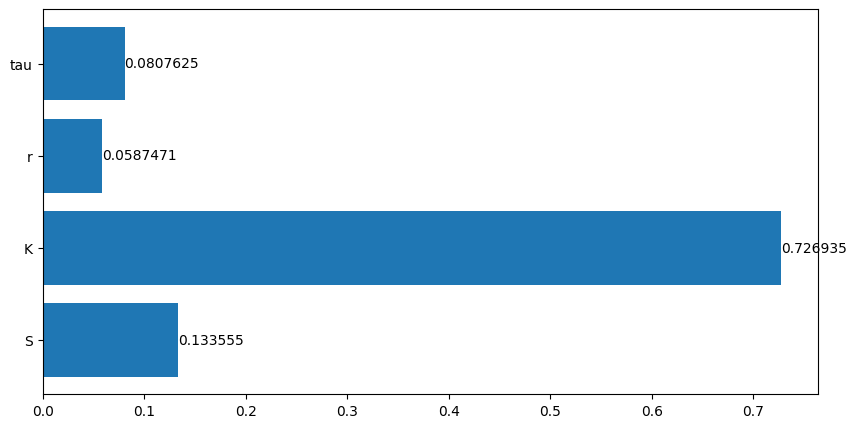

In [ ]:
importance = rf_cls_model.feature_importances_

colname = []
importance_list = []

# summarize feature importance
for i, v in enumerate(zip(list(['S', 'K', 'r', 'tau']), importance)):
    if v[1] > 0:
        print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
        colname.append(v[0])
        importance_list.append(v[1])
    
# plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))
fig.set_dpi(100)
bars = ax.barh(colname, importance_list)
ax.bar_label(bars)
plt.show()

## Linear discriminant analysis,

In [ ]:
lda_cls_model = classification_model(model = LinearDiscriminantAnalysis(),
                                 features = ['S', 'K', 'r', 'tau'])

In-sample Classification error: 0.0872683801554095
Cross validation Classification error: 0.09084331337325349


# Best Subset Selection

In [ ]:
def processSubset(feature_set):
    X_train_subset = sm.add_constant(X_reg[list(feature_set)])
    model = sm.OLS(y_reg, X_train_subset)
    regr = model.fit()
    RSS = ((regr.predict(X_train_subset) - y_reg) ** 2).sum()
    return {"model": regr, "RSS": RSS}

# Define the getBest function to return the best model with k predictors
def getBest(k):
    results = []
    for combo in itertools.combinations(X_reg.columns, k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

In [ ]:
models = pd.DataFrame(columns=["RSS", "model"])
for i in range(1, 6):
    models.loc[i-1] = getBest(i)

# Print the summary statistics for each model
for i in range(len(models)):
    print("Model", i+1, "with", i+1, "predictors:")
    print(models.loc[i, "model"].summary())

Model 1 with 1 predictors:
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 1.055e+04
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        05:34:49   Log-Likelihood:                -5129.9
No. Observations:                1673   AIC:                         1.026e+04
Df Residuals:                    1671   BIC:                         1.027e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5746    

Text(0, 0.5, 'BIC')

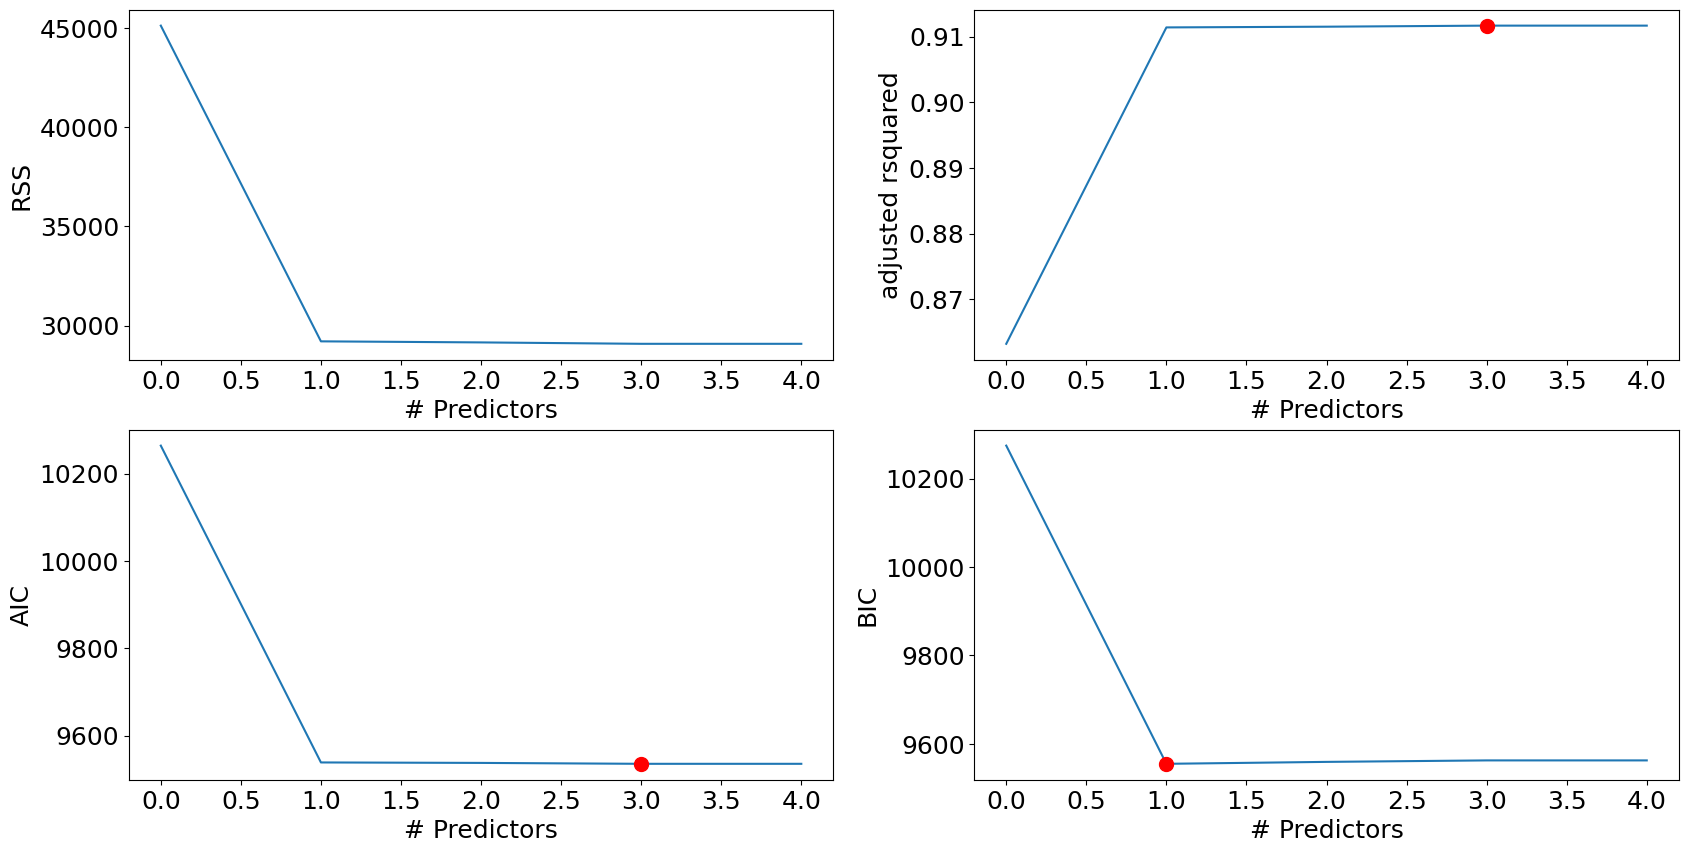

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':18,'lines.markersize':10})
plt.subplot(2,2,1)
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')


rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')


aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')


bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

# Prediction

In [ ]:
test_value = rf_model.predict(test_df[['S', 'K', 'r', 'tau']])
test_BS = rf_cls_model.predict(test_df[['S', 'K', 'r', 'tau']])

group_x_prediction = pd.DataFrame({"Value": test_value, "BS": test_BS})

## to_csv

In [ ]:
group_x_prediction.to_csv("group_x_prediction.csv", index = False)

In [ ]:
group_x_prediction

,Value,BS
0,1.330600,1
1,17.396307,0
2,10.170911,0
3,22.489797,0
4,15.204581,0
...,...,...
1115,11.570292,1
1116,0.400403,1
1117,0.413003,1
1118,25.293606,0


## Plot

<Axes: xlabel='S', ylabel='Value'>

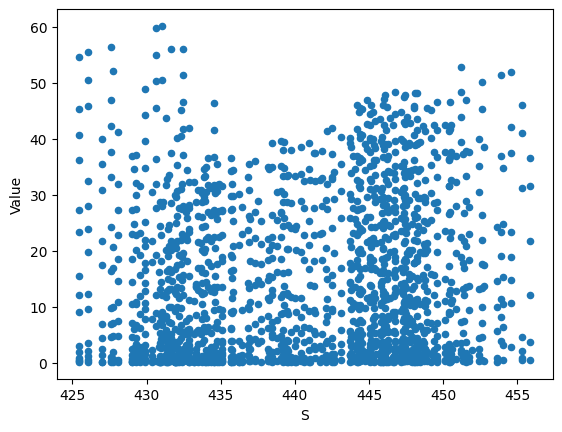

In [ ]:
train_df_cleaned.plot.scatter('S', 'Value')

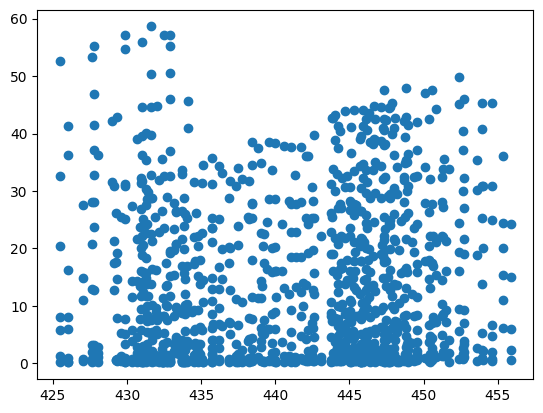

In [ ]:
plt.scatter(test_df['S'], test_value)

<Axes: xlabel='K', ylabel='Value'>

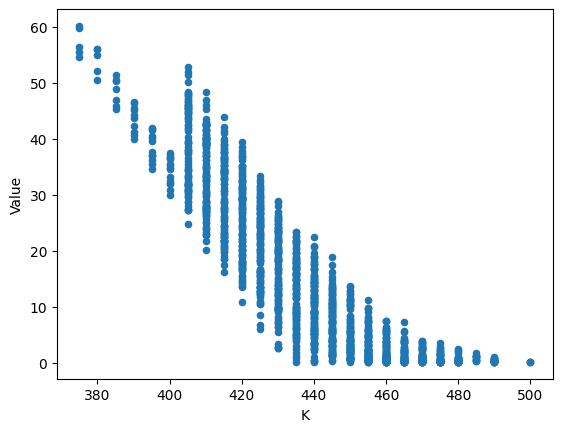

In [ ]:
train_df_cleaned.plot.scatter('K', 'Value')

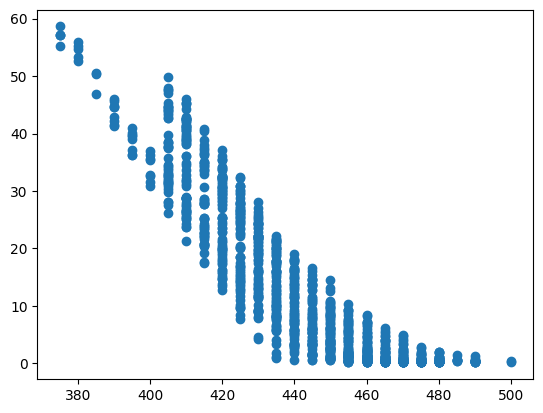

In [ ]:
plt.scatter(test_df['K'], test_value)